In [25]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Set paths
DATA_DIR = "E://Projects//digits"
SAMPLE_RATE = 16000
N_MFCC = 39
MAX_LEN = 100  # number of time frames
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 0.001

In [3]:
# Function to extract MFCC features
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
    # Pad or truncate to fixed length
    if mfcc.shape[1] < MAX_PAD_LEN:
        pad_width = MAX_PAD_LEN - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :MAX_PAD_LEN]
    return mfcc.T  # Time-major

In [4]:
# Step 1: Dataset class
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, label_encoder):
        self.file_paths = file_paths
        self.labels = label_encoder.transform(labels)
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        mfcc = self.extract_mfcc(file_path)
        return torch.tensor(mfcc, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

    def extract_mfcc(self, file_path):
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
        if mfcc.shape[1] < MAX_LEN:
            pad_width = MAX_LEN - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :MAX_LEN]
        return mfcc.T  # (Time, Features)


In [5]:
# Step 2: Prepare data
def load_data(data_dir):
    file_paths = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                if file_name.endswith('.wav'):
                    file_paths.append(os.path.join(label_dir, file_name))
                    labels.append(label)
    return file_paths, labels

In [6]:
file_paths, labels = load_data(DATA_DIR)
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

In [8]:
train_dataset = AudioDataset(X_train, y_train, label_encoder)
test_dataset = AudioDataset(X_test, y_test, label_encoder)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [10]:
# Step 3: Define Model
class BiLSTMGRUModel(nn.Module):
    def __init__(self, num_classes):
        super(BiLSTMGRUModel, self).__init__()
        self.bilstm = nn.LSTM(input_size=N_MFCC, hidden_size=128, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(input_size=256, hidden_size=64, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x, _ = self.bilstm(x)
        x, _ = self.gru(x)
        x = torch.mean(x, dim=1)  # global average pooling
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [11]:
num_classes = len(label_encoder.classes_)
model = BiLSTMGRUModel(num_classes)

In [12]:
# Step 4: Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BiLSTMGRUModel(
  (bilstm): LSTM(39, 128, batch_first=True, bidirectional=True)
  (gru): GRU(256, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=11, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Training accuracy calculation
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Validation accuracy
    model.eval()
    correct_test = total_test = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Loss: {avg_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, "
          f"Test Acc: {test_accuracy:.4f}")


Epoch 1/30, Loss: 2.3144, Train Acc: 0.2468, Test Acc: 0.2532
Epoch 2/30, Loss: 2.2619, Train Acc: 0.2614, Test Acc: 0.2532
Epoch 3/30, Loss: 2.1729, Train Acc: 0.2662, Test Acc: 0.2597
Epoch 4/30, Loss: 2.0883, Train Acc: 0.3036, Test Acc: 0.2727
Epoch 5/30, Loss: 1.9322, Train Acc: 0.3360, Test Acc: 0.3766
Epoch 6/30, Loss: 1.8049, Train Acc: 0.3782, Test Acc: 0.3247
Epoch 7/30, Loss: 1.7565, Train Acc: 0.4091, Test Acc: 0.4026
Epoch 8/30, Loss: 1.5069, Train Acc: 0.4497, Test Acc: 0.4351
Epoch 9/30, Loss: 1.5915, Train Acc: 0.3994, Test Acc: 0.4935
Epoch 10/30, Loss: 1.3527, Train Acc: 0.4805, Test Acc: 0.4870
Epoch 11/30, Loss: 1.3054, Train Acc: 0.5130, Test Acc: 0.3961
Epoch 12/30, Loss: 1.2420, Train Acc: 0.5130, Test Acc: 0.5065
Epoch 13/30, Loss: 1.1039, Train Acc: 0.6071, Test Acc: 0.5714
Epoch 14/30, Loss: 1.0134, Train Acc: 0.6006, Test Acc: 0.6169
Epoch 15/30, Loss: 1.0370, Train Acc: 0.6039, Test Acc: 0.5844
Epoch 16/30, Loss: 0.9572, Train Acc: 0.6429, Test Acc: 0.6104
E

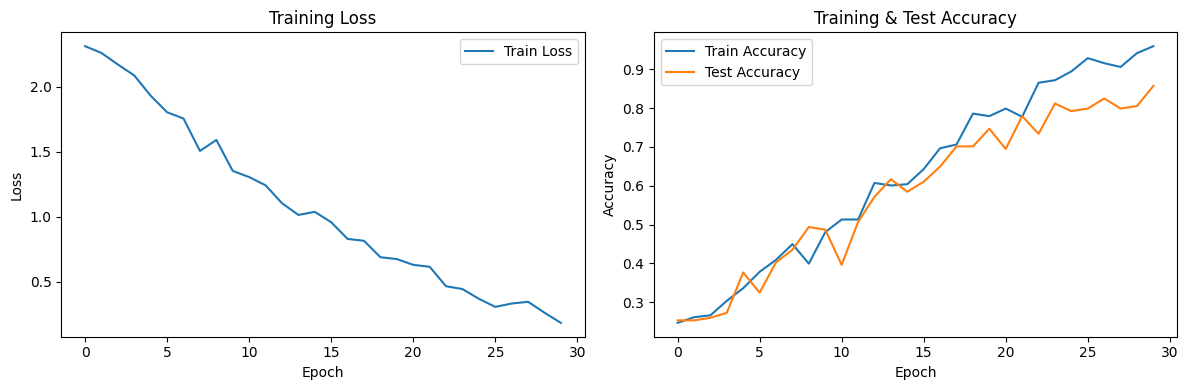

In [16]:
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Test Accuracy')

plt.tight_layout()
plt.show()


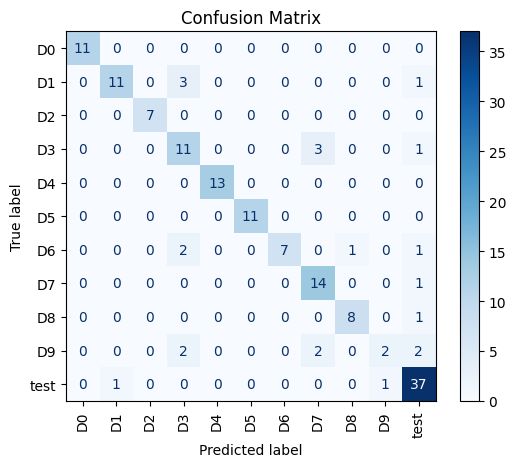

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 6: Confusion Matrix
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


In [24]:
# Classification metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)

accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=label_encoder.classes_))


Accuracy:  0.9156
Precision: 0.9303
Recall:    0.9156
F1 Score:  0.9154

Classification Report:
              precision    recall  f1-score   support

          D0       1.00      0.76      0.87        17
          D1       0.93      1.00      0.97        14
          D2       1.00      0.88      0.94        17
          D3       0.80      0.94      0.86        17
          D4       1.00      1.00      1.00        15
          D5       0.95      1.00      0.98        20
          D6       0.92      0.92      0.92        12
          D7       0.71      1.00      0.83        12
          D8       0.92      1.00      0.96        11
          D9       1.00      0.74      0.85        19

    accuracy                           0.92       154
   macro avg       0.92      0.92      0.92       154
weighted avg       0.93      0.92      0.92       154



In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

testFile="E://Projects//digits//D4//F02_B1_D4_M8.wav"
MAX_PAD_LEN = 100

featTest = extract_features(testFile)

input_tensor = torch.tensor(featTest).unsqueeze(0).float().to(device)

with torch.no_grad():
    op = model(input_tensor)

_, pred = torch.max(op,1)
print(pred)

classes = ["D0", "D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9"]
classNames = ["zero","one","two","three","four","five","six","seven","eight","nine"]

value = pred[0].item()
print(classNames[value])


tensor([4], device='cuda:0')
four


In [22]:
import pyttsx3

engine = pyttsx3.init()
engine.say(classNames[value])
engine.runAndWait()
